05-observation-based-mechanism.ipynb
======================

**Things to do**
* Find how to get the total size of a dataframe.
* Test code.
* Find the number of unique cheaters who harmed other players severely.

## Load packages and read tables.

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import StructType, StructField, LongType
import pubg_analysis as pubg

In [2]:
# Read a table that contains edges.
td = spark.read.parquet("s3://jinny-capstone-data-test/data_for_obs_mech.parquet")
td.registerTempTable("td")

# Read a table that contains cheater data.
cheaters = spark.read.parquet("s3://jinny-capstone-data-test/cheater_info.parquet")
cheaters.registerTempTable("cheaters")

# Read a table that contains nodes.
nodes = spark.read.parquet("s3://jinny-capstone-data-test/nodes.parquet")
nodes.registerTempTable("nodes")

In [3]:
# Show the first few rows of each dataset.
td.show(5)
cheaters.show(5)
nodes.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|000ec388-a3d7-422...|account.c84796ba7...|    NA|       0|account.5028c61d0...|    NA|       0|2019-03-03 16:14:...|2019-03-03|
|000ec388-a3d7-422...|account.cba82f51c...|    NA|       0|account.b347ea78f...|    NA|       0|2019-03-03 16:33:...|2019-03-03|
|000ec388-a3d7-422...|account.8f011f0fd...|    NA|       0|account.e2f45b350...|    NA|       0|2019-03-03 16:16:...|2019-03-03|
|000ec388-a3d7-422...|account.73324618c...|    NA|       0|account.7911e1c3d...|    NA|       0|2019-03-03 16:12:...|2019-03-03|
|000ec388-a3d7-422...|account.ba7ff30f8...|    NA|       0|account.4e93215ae...|    NA|       0|2

## 1. Count the number of motifs on the empirical network.

In [4]:
res_tab = pubg.add_level_of_harm(td, 30)
res_tab.registerTempTable("new_td")
res_tab.show(5)

+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+------+
|                 mid|                 src|src_flag|                 dst|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.1866a3c61...|       0|account.cd31e8ad9...|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|       0|account.e5e3583f7...|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.bdea579b5...|       0|account.695c4609e...|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|       0|account.16c355b96...|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|       0|account.789d5bcf9...|       0|2019-03-03 15:56:...|2019-03-03|     1|
+--------------------+--

In [9]:
# First, add information of killers.
src_info = spark.sql("""SELECT mid, src, start_date AS src_sd, src_bd, src_flag, 
                        dst, dst_bd, dst_flag, time, m_date, damage 
                        FROM new_td t JOIN nodes n ON t.src = n.id""")
src_info.registerTempTable("src_info")

# Add information of victims.
full_info = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, 
                         dst, start_date AS dst_sd, dst_bd, dst_flag, time, m_date, damage 
                         FROM src_info s JOIN nodes n ON s.dst = n.id""")
full_info.registerTempTable("full_info")

# Add information of cheaters.
add_flags = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag,
                         CASE WHEN src_bd >= m_date AND src_sd <= m_date 
                         AND src_flag == 1 THEN 1 ELSE 0 END AS src_curr_flag, 
                         dst, dst_sd, dst_bd, dst_flag,
                         CASE WHEN dst_bd >= m_date AND dst_sd <= m_date 
                         AND dst_flag == 1 THEN 1 ELSE 0 END AS dst_curr_flag, time, m_date, damage 
                         FROM full_info ORDER BY mid, time""")
add_flags.registerTempTable("add_flags")

legit_matches = spark.sql("""SELECT mid 
                             FROM (SELECT mid, SUM(src_curr_flag) AS c_kills FROM add_flags GROUP BY mid) 
                             WHERE c_kills > 0""")
legit_matches.registerTempTable("legit_matches")

records = spark.sql("""SELECT r.mid, src, src_sd, src_bd, src_flag, src_curr_flag, 
                       dst, dst_sd, dst_bd, dst_flag, dst_curr_flag, time, m_date, damage 
                       FROM add_flags r JOIN legit_matches l ON r.mid = l.mid""")
records.registerTempTable("records")

records = spark.sql("SELECT *, ROW_NUMBER() OVER (PARTITION BY mid ORDER BY time) AS aid FROM records")
records.registerTempTable("records")

+--------------------+--------------------+----------+----------+--------+-------------+--------------------+------+------+--------+-------------+--------------------+----------+------+---+
|                 mid|                 src|    src_sd|    src_bd|src_flag|src_curr_flag|                 dst|dst_sd|dst_bd|dst_flag|dst_curr_flag|                time|    m_date|damage|aid|
+--------------------+--------------------+----------+----------+--------+-------------+--------------------+------+------+--------+-------------+--------------------+----------+------+---+
|05c04ee8-6c76-4b0...|account.87b1996c3...|        NA|        NA|       0|            0|account.7ff55d8ce...|    NA|    NA|       0|            0|2019-03-02 18:37:...|2019-03-02|     0|  1|
|05c04ee8-6c76-4b0...|account.57db0ba5a...|        NA|        NA|       0|            0|account.f7703cf3b...|    NA|    NA|       0|            0|2019-03-02 18:38:...|2019-03-02|     0|  2|
|05c04ee8-6c76-4b0...|account.2d5102e2e...|       

In [10]:
# Get a list of killings done by cheaters.
kills_done_by_cheaters = spark.sql("""SELECT mid, src AS killer, time, aid FROM records 
                                      WHERE src_curr_flag = 1""")
kills_done_by_cheaters.registerTempTable("kills_done_by_cheaters")

# Get a table of players (both killers and victims) who observed killings done by cheaters when they were alive.
observers_tab = spark.sql("""SELECT id, 
                             TO_DATE(CAST(UNIX_TIMESTAMP(start_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS start_date, 
                             TO_DATE(CAST(UNIX_TIMESTAMP(m_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS m_date, 
                             CAST(DATEDIFF(start_date, m_date) AS INT) AS period, killer, 
                             COUNT(*) AS obs, SUM(damage) AS sev_dam 
                             FROM (SELECT s.mid, s.src AS id, s.src_sd AS start_date, s.src_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid < k.aid 
                             WHERE src_flag == 1 AND src_sd != 'NA' AND src != killer AND src_curr_flag == 0
                             UNION
                             SELECT s.mid, s.src AS id, s.src_sd, s.src_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid > k.aid 
                             WHERE src_flag == 1 AND src_sd != 'NA' AND src != killer AND src_curr_flag == 0
                             UNION
                             SELECT s.mid, s.dst AS id, s.dst_sd, s.dst_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid > k.aid 
                             WHERE dst_flag == 1 AND dst_sd != 'NA' AND dst != killer AND dst_curr_flag == 0) 
                             GROUP BY id, start_date, m_date, killer""")
observers_tab.registerTempTable("observers_tab")

observers_tab.show(20)
print(observers_tab.count())

+--------------------+----------+----------+------+--------------------+---+-------+
|                  id|start_date|    m_date|period|              killer|obs|sev_dam|
+--------------------+----------+----------+------+--------------------+---+-------+
|account.27478c512...|2019-03-02|2019-03-01|     1|account.f1bf619de...| 16|      8|
|account.216ad15bd...|2019-03-02|2019-03-01|     1|account.05e7638fb...|  2|      2|
|account.6dccf1b38...|2019-03-02|2019-03-01|     1|account.0a54b3498...|  1|      0|
|account.49a8333dc...|2019-03-02|2019-03-01|     1|account.b5b88ac71...|  2|      0|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|account.caeaf4f68...|  9|      9|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|account.f450cac80...|  2|      0|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|account.1cb8b6fcd...|  6|      3|
|account.d87ddfa9b...|2019-03-03|2019-03-02|     1|account.9619606b3...|  4|      2|
|account.903b83e20...|2019-03-03|2019-03-01|     2|account.289e5d

In [11]:
# Get the table that contains the total number of observations and the number of unique cheaters.
obs_info = spark.sql("""SELECT id, start_date, SUM(obs) AS total_obs, SUM(sev_dam) AS total_sev_dam, 
                        COUNT(DISTINCT killer) AS uniq_cheaters FROM observers_tab 
                        GROUP BY id, start_date""")
obs_info.registerTempTable("obs_info")
obs_info.show(20)

+--------------------+----------+---------+-------------+-------------+
|                  id|start_date|total_obs|total_sev_dam|uniq_cheaters|
+--------------------+----------+---------+-------------+-------------+
|account.71aea180f...|2019-03-02|        6|            3|            1|
|account.d974dde55...|2019-03-02|       26|           15|            4|
|account.d2cb5110d...|2019-03-03|        2|            0|            1|
|account.293b34d31...|2019-03-02|        3|            3|            2|
|account.7747ed775...|2019-03-02|        1|            0|            1|
|account.394573912...|2019-03-02|        1|            0|            1|
|account.fde9def4e...|2019-03-03|       36|           16|            1|
|account.213368b1a...|2019-03-02|       13|            0|            1|
|account.e493e8036...|2019-03-02|       23|            0|            3|
|account.d87ddfa9b...|2019-03-03|        4|            2|            1|
|account.27478c512...|2019-03-02|       50|           16|       

In [12]:
# Get the date when the player first observed cheating.
first_m_dates = spark.sql("""SELECT * 
                             FROM (SELECT id, m_date, period, ROW_NUMBER() OVER (PARTITION BY id ORDER BY m_date) 
                             AS rownumber FROM observers_tab) WHERE rownumber IN (1)""")
first_m_dates.registerTempTable("first_m_dates")

In [13]:
add_dates = spark.sql("""SELECT o.id, o.start_date, f.m_date, f.period, 
                         o.total_obs, o.total_sev_dam, o.uniq_cheaters 
                         FROM obs_info o LEFT JOIN first_m_dates f ON o.id = f.id""")
add_dates.show(10)

+--------------------+----------+----------+------+---------+-------------+-------------+
|                  id|start_date|    m_date|period|total_obs|total_sev_dam|uniq_cheaters|
+--------------------+----------+----------+------+---------+-------------+-------------+
|account.8d69e3520...|2019-03-02|2019-03-01|     1|       59|           21|            7|
|account.11dbd81ee...|2019-03-02|2019-03-01|     1|        9|            1|            4|
|account.da1a6fa0b...|2019-03-02|2019-03-01|     1|       35|           17|            1|
|account.27478c512...|2019-03-02|2019-03-01|     1|       50|           16|            6|
|account.e493e8036...|2019-03-02|2019-03-01|     1|       23|            0|            3|
|account.642deac91...|2019-03-02|2019-03-01|     1|        2|            0|            1|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|       18|            0|            3|
|account.71aea180f...|2019-03-02|2019-03-01|     1|        6|            3|            1|
|account.5

In [14]:
# Store the summary table in the S3 bucket for the later use.
add_dates.write.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/obs_tab.parquet")

In [ ]:
obs_info_df = add_dates.toPandas()
obs_info_df.to_csv('obs_info_df.csv')

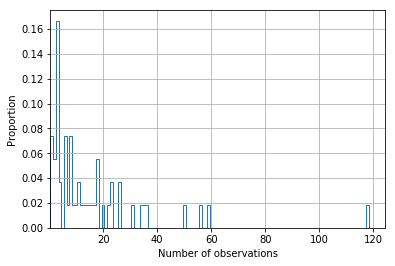

In [15]:
# Plot the distribution of the total number of observations.
# Show the distribution of the number of times the player observed cheating before the transition happened.
# In this case, we allow duplicate pairs of cheater and observer. 
# as there are some players who have observed the same cheaters more than once. 
bins = np.arange(0, obs_info_df['total_obs'].max() + 1.5) - 0.5
fig = obs_info_df.hist(column = 'total_obs', histtype='step', bins = bins, 
                       weights=np.zeros_like(obs_info_df['total_obs'])+1./len(obs_info_df['total_obs']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of observations")
plt.ylabel("Proportion")
plt.title("")
plt.show() 

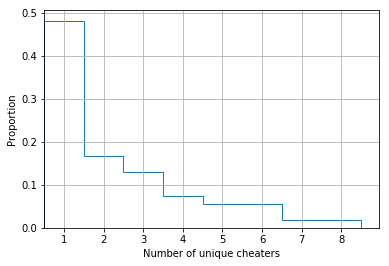

In [16]:
# Plot the distribution of the number of unique cheaters.
# In this case, we consider only unique pairs of cheater and observer.
bins = np.arange(0, obs_info_df['uniq_cheaters'].max() + 1.5) - 0.5
fig = obs_info_df.hist(column = 'uniq_cheaters', histtype='step', bins = bins, 
                       weights=np.zeros_like(obs_info_df['uniq_cheaters'])+1./len(obs_info_df['uniq_cheaters']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of unique cheaters")
plt.ylabel("Proportion")
plt.title("")
plt.show()

## 2. Reuse the mapping table in the S3 bucket to create randomised networks.

In [17]:
# Read a table that contains team membership data.
team_info = spark.read.parquet("s3://jinny-capstone-data-test/team_data.parquet")
team_info.registerTempTable("team_ids")
team_info.show(5)

+--------------------+--------------------+---+
|                 mid|                  id|tid|
+--------------------+--------------------+---+
|a2983171-7f4b-41a...|account.e71c81b51...|  8|
|87fa7a64-8296-46d...|account.4fc0cf786...| 25|
|9d8128bb-62b9-4db...|account.05c8f38ba...| 18|
|7a8874eb-ef3b-451...|account.d53c68f6a...| 10|
|eaf29706-a41b-4a1...|account.562041b51...|  2|
+--------------------+--------------------+---+
only showing top 5 rows



In [18]:
# Read the mapping table.
map_tab = spark.read.parquet("s3://jinny-capstone-data-test/mapping-tables/map_tab_1.parquet")
map_tab.registerTempTable("map_tab")
map_tab.show(5)

+--------------------+--------------------+---------+--------+--------------------+---------+--------+
|            match_id|            original|orig_flag|orig_tid|          randomised|rand_flag|rand_tid|
+--------------------+--------------------+---------+--------+--------------------+---------+--------+
|02a5ab4b-0fbb-490...|account.d040b4192...|        0|      20|account.b687d583a...|        0|      20|
|02a5ab4b-0fbb-490...|account.40f46fbba...|        0|       4|account.ab55155a3...|        0|       4|
|02a5ab4b-0fbb-490...|account.d8912ca79...|        0|      22|account.c8c1c3332...|        0|      22|
|02a5ab4b-0fbb-490...|account.f23ae5388...|        0|      12|account.34fcd0ba4...|        0|      12|
|02a5ab4b-0fbb-490...|account.8b6abd5bc...|        0|       1|account.b2f12e113...|        0|       1|
+--------------------+--------------------+---------+--------+--------------------+---------+--------+
only showing top 5 rows



In [19]:
# Get randomised gameplay logs.
temp_rand_logs = spark.sql("""SELECT mid, src, randomised AS new_src, dst, time, m_date 
                              FROM td t JOIN map_tab m ON t.src = m.original AND t.mid = m.match_id""")
temp_rand_logs.registerTempTable("temp_rand_logs")
randomised_logs = spark.sql("""SELECT mid, new_src AS src, randomised AS dst, time, m_date 
                               FROM temp_rand_logs t JOIN map_tab m 
                               ON t.dst = m.original AND t.mid = m.match_id""")

randomised_logs.show(5)
randomised_logs.registerTempTable("randomised_logs")

+--------------------+--------------------+--------------------+--------------------+----------+
|                 mid|                 src|                 dst|                time|    m_date|
+--------------------+--------------------+--------------------+--------------------+----------+
|8944786b-0021-4a4...|account.88bb45d22...|account.0001531a9...|2019-03-03 17:50:...|2019-03-03|
|4a5152fa-e942-47d...|account.e80504895...|account.0003b5c76...|2019-03-01 17:08:...|2019-03-01|
|dd6286b5-8c40-437...|account.d4a4282a8...|account.000e6d24c...|2019-03-01 15:48:...|2019-03-01|
|54a9f240-74d9-404...|account.49f7414ca...|account.6064680b3...|2019-03-01 10:09:...|2019-03-01|
|53ca0690-f2d8-480...|account.d98d7526c...|account.c47167ad7...|2019-03-03 05:04:...|2019-03-03|
+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## 3. Count the number of motifs on the randomised network.

In [24]:
# Add the cheating flags of players.
add_flags = spark.sql("""SELECT mid, src, cheating_flag AS src_flag, dst, time, m_date 
                         FROM randomised_logs r JOIN nodes n ON r.src = n.id""")
add_flags.registerTempTable("add_flags")
randomised_logs = spark.sql("""SELECT mid, src, src_flag, dst, cheating_flag AS dst_flag, time, m_date 
                               FROM add_flags r JOIN nodes n ON r.dst = n.id""")
randomised_logs.registerTempTable("randomised_logs")
randomised_logs.show(5)

+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+
|                 mid|                 src|src_flag|                 dst|dst_flag|                time|    m_date|
+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+
|fcaf8c76-4e7a-4b9...|account.a0bc68e5e...|       0|account.001017dce...|       0|2019-03-02 06:56:...|2019-03-02|
|297788d0-ef37-4ab...|account.c419eaa2e...|       0|account.001017dce...|       0|2019-03-02 07:29:...|2019-03-02|
|d7b4a476-007b-4e7...|account.ff01e3c0d...|       0|account.0017aeb1b...|       0|2019-03-01 08:35:...|2019-03-01|
|4f356644-a887-49f...|account.d37ba5b3e...|       0|account.00399d4c2...|       0|2019-03-01 04:13:...|2019-03-01|
|d8324042-12e1-401...|account.e2d270189...|       0|account.00399d4c2...|       0|2019-03-01 05:01:...|2019-03-01|
+--------------------+--------------------+--------+--------------------+-------

In [26]:
randomised_logs.registerTempTable("td")
rand_logs = pubg.add_level_of_harm(randomised_logs, 30)
rand_logs.registerTempTable("new_rand_td")
rand_logs.show(5)

+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+------+
|                 mid|                 src|src_flag|                 dst|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+--------+--------------------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.05dd3a28f...|       0|account.cd31e8ad9...|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.1866a3c61...|       0|account.09a6fd9cc...|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|       0|account.95d3d342f...|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.95d3d342f...|       0|account.6541e80e8...|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.95d3d342f...|       0|account.16c355b96...|       0|2019-03-03 15:56:...|2019-03-03|     1|
+--------------------+--

In [29]:
# First, add information of killers.
src_info = spark.sql("""SELECT mid, src, start_date AS src_sd, ban_date AS src_bd, 
                        src_flag, dst, dst_flag, time, m_date, damage 
                        FROM new_rand_td t JOIN nodes n ON t.src = n.id""")
src_info.registerTempTable("src_info")

# Add information of victims.
full_info = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, 
                         dst, start_date AS dst_sd, ban_date AS dst_bd, dst_flag, 
                         time, m_date, damage 
                         FROM src_info s JOIN nodes n ON s.dst = n.id ORDER BY src_flag""")
full_info.registerTempTable("full_info")

# Add information of cheaters.
add_flags = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag,
                         CASE WHEN src_bd >= m_date AND src_sd <= m_date 
                         AND src_flag == 1 THEN 1 ELSE 0 END AS src_curr_flag, 
                         dst, dst_sd, dst_bd, dst_flag,
                         CASE WHEN dst_bd >= m_date AND dst_sd <= m_date 
                         AND dst_flag == 1 THEN 1 ELSE 0 END AS dst_curr_flag, time, m_date, damage 
                         FROM full_info ORDER BY mid, time""")
add_flags.registerTempTable("add_flags")

legit_matches = spark.sql("""SELECT mid 
                             FROM (SELECT mid, SUM(src_curr_flag) AS c_kills FROM add_flags GROUP BY mid) 
                             WHERE c_kills > 0""")
legit_matches.registerTempTable("legit_matches")

records = spark.sql("""SELECT r.mid, src, src_sd, src_bd, src_flag, src_curr_flag, 
                       dst, dst_sd, dst_bd, dst_flag, dst_curr_flag, time, m_date, damage 
                       FROM add_flags r JOIN legit_matches l ON r.mid = l.mid""")
records.registerTempTable("records")

records = spark.sql("SELECT *, ROW_NUMBER() OVER (PARTITION BY mid ORDER BY time) AS aid FROM records")
records.registerTempTable("records")

In [30]:
# Get a list of killings done by cheaters.
kills_done_by_cheaters = spark.sql("""SELECT mid, src AS killer, time, aid FROM records 
                                      WHERE src_curr_flag = 1""")
kills_done_by_cheaters.registerTempTable("kills_done_by_cheaters")

# Get a table of players (both killers and victims) who observed killings done by cheaters when they were alive.
observers_tab = spark.sql("""SELECT id, 
                             TO_DATE(CAST(UNIX_TIMESTAMP(start_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS start_date, 
                             TO_DATE(CAST(UNIX_TIMESTAMP(m_date, 'yyyy-MM-dd') AS TIMESTAMP)) AS m_date, 
                             CAST(DATEDIFF(start_date, m_date) AS INT) AS period, killer, 
                             COUNT(*) AS obs, SUM(damage) AS sev_dam 
                             FROM (SELECT s.mid, s.src AS id, s.src_sd AS start_date, s.src_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid < k.aid 
                             WHERE src_flag == 1 AND src_sd != 'NA' AND src != killer AND src_curr_flag == 0
                             UNION
                             SELECT s.mid, s.src AS id, s.src_sd, s.src_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid > k.aid 
                             WHERE src_flag == 1 AND src_sd != 'NA' AND src != killer AND src_curr_flag == 0
                             UNION
                             SELECT s.mid, s.dst AS id, s.dst_sd, s.dst_bd, k.time, s.m_date, 
                             s.damage, k.killer, k.aid 
                             FROM records s LEFT JOIN kills_done_by_cheaters k ON s.mid = k.mid AND s.aid > k.aid 
                             WHERE dst_flag == 1 AND dst_sd != 'NA' AND dst != killer AND dst_curr_flag == 0) 
                             GROUP BY id, start_date, m_date, killer""")
observers_tab.registerTempTable("observers_tab")
observers_tab.show(20)
print(observers_tab.count())

+--------------------+----------+----------+------+--------------------+---+-------+
|                  id|start_date|    m_date|period|              killer|obs|sev_dam|
+--------------------+----------+----------+------+--------------------+---+-------+
|account.9efd5b93e...|2019-03-02|2019-03-01|     1|account.869fc2de3...|  1|      1|
|account.27478c512...|2019-03-02|2019-03-01|     1|account.f1bf619de...|  7|      7|
|account.6dccf1b38...|2019-03-02|2019-03-01|     1|account.0a54b3498...|  1|      0|
|account.49a8333dc...|2019-03-02|2019-03-01|     1|account.b5b88ac71...|  1|      0|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|account.caeaf4f68...|  9|      9|
|account.d87ddfa9b...|2019-03-03|2019-03-02|     1|account.9619606b3...|  4|      2|
|account.903b83e20...|2019-03-03|2019-03-01|     2|account.289e5d7fb...|  1|      0|
|account.29263c240...|2019-03-02|2019-03-01|     1|account.6f8b0c2d0...|  4|      0|
|account.27478c512...|2019-03-02|2019-03-01|     1|account.299b49

In [31]:
# Get the table that contains the total number of observations and the number of unique cheaters.
obs_info = spark.sql("""SELECT id, start_date, SUM(obs) AS total_obs, SUM(sev_dam) AS total_sev_dam, 
                        COUNT(DISTINCT killer) AS uniq_cheaters FROM observers_tab 
                        GROUP BY id, start_date""")
obs_info.registerTempTable("obs_info")

# Get the date when the player first observed cheating.
first_m_dates = spark.sql("""SELECT * 
                             FROM (SELECT id, m_date, period, ROW_NUMBER() OVER (PARTITION BY id ORDER BY m_date) 
                             AS rownumber FROM observers_tab) WHERE rownumber IN (1)""")
first_m_dates.registerTempTable("first_m_dates")

add_dates = spark.sql("""SELECT o.id, o.start_date, f.m_date, f.period, 
                         o.total_obs, o.total_sev_dam, o.uniq_cheaters 
                         FROM obs_info o LEFT JOIN first_m_dates f ON o.id = f.id""")
add_dates.show(10)

# Download an excel file that contains the summary table.
obs_info_df = add_dates.toPandas()
obs_info_df.to_csv('rand_obs_info_df.csv')